# Dataset generation

## 1. Import

In [184]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from torch_geometric.utils.convert import from_networkx


import pickle

## 2. Utils

In [185]:
def draw(graph, ax):
    """
    Draws the graph as a matplotlib plot.
    Depots are colored in red. Edges that have been
    traveresed
    """

    # draw nodes according to color and position attribute
    pos = nx.get_node_attributes(graph, "coordinates")
    nx.draw_networkx_nodes(
        graph, pos, ax=ax, node_size=100
    )
    labels_pos = {k: (v + np.array([0, 0.03])) for k, v in pos.items()}
    nx.draw_networkx_labels(
        graph, labels_pos, ax=ax
    )

    # draw edges
    nx.draw_networkx_edges(graph, pos)

## 3. Generating Distance Matrices

In [186]:
def build_graph(num_nodes):
    k = num_nodes // 2
    G = nx.empty_graph(num_nodes, create_using=nx.Graph())
    node_position = {
        i: coordinates for i, coordinates in enumerate(np.random.rand(num_nodes, 2))
    }
    nx.set_node_attributes(G, node_position, "coordinates")

    positions = np.array([node_position[index] for index in range(num_nodes)])
    distances = cdist(positions, positions)

    # add distance as feature vector per node
    for i in range(num_nodes):
        distance_attribute = {
            j: {f'dist{i}' : distances[i,j]} for j in range(num_nodes)
        }
        nx.set_node_attributes(G, distance_attribute)

    # add edges between nearest nodes
    edges = []
    for i in range(num_nodes):
        partition = np.argsort(distances[i])
        idx = partition[1:k+1]
        for j in range(k):
            edges.append((i,idx[j]))
    G.add_edges_from(edges)
    return G, distances

G, distances = build_graph(10)
print(G.number_of_edges())

29


## 4. Building Solutions

In [187]:
from ortools.constraint_solver import pywrapcp

# Distance callback
def get_optimal_route(distances):
    # Create a callback to calculate distances between cities.
    def create_distance_callback(dist_matrix):
        def distance_callback(from_node, to_node):
            return int(dist_matrix[from_node][to_node])
        return distance_callback

    tsp_size = distances.shape[0]
    num_vehicles = 1
    depot = 0

    # Convert distances to interger (MIP)
    dist_matrix = (10000*distances).astype(int)

    # Create routing model
    if tsp_size > 0:
        manager = pywrapcp.RoutingIndexManager(tsp_size, num_vehicles, depot)
        routing = pywrapcp.RoutingModel(manager)
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        # Create the distance callback.
        dist_callback = create_distance_callback(dist_matrix)
        transit_callback_index = routing.RegisterTransitCallback(dist_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Solve the problem.
        assignment = routing.SolveWithParameters(search_parameters)
        if assignment:
            # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
            route_number = 0

            # Index of the variable for the starting node.
            index = routing.Start(route_number)

            # Variable store
            route = []
            score = .0
            prev = index
            while not routing.IsEnd(index):
                # Convert variable indices to node indices in the displayed route.
                route.append(index)
                score += distances[prev, index]
                index = assignment.Value(routing.NextVar(index))
            return route, score

route, obj = get_optimal_route(distances)
print(route, obj)

[0, 4, 7, 1, 5, 6, 8, 2, 9, 3] 6.028453500766744


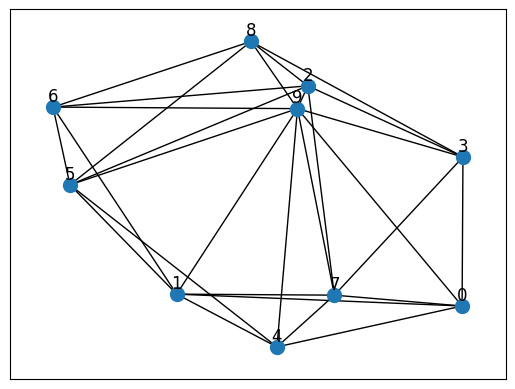

In [188]:
fig, ax = plt.subplots()
draw(G, ax)

## Generate dataset

In [189]:
def build_dataset(size, num_nodes):
    graphs = []
    targets = []
    opts = []
    for i in range(size):
        graph, dist_mat = build_graph(num_nodes)
        graph_pyg = from_networkx(graph, [f'dist{i}' for i in range(num_nodes)])
        opt_route, opt_ojb = get_optimal_route(dist_mat)

        # define target variable (NxN)
        target = np.zeros_like(graph_pyg["x"])
        for j,node in enumerate(opt_route):
            target[j,node] = 1.

        # Saving
        graphs.append(graph_pyg)
        targets.append(target)
        opts.append(opt_ojb)
    return graphs, targets, opts

data = build_dataset(100,10)


In [190]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(data, file)